# Cleanup & Preprocess - Ngrams

---

*Purpose*

- The **DocumentToBigramCounterTransformer** class is generalized into a **DocumentToNgramCounterTransformer** class. 


- More comprehensive grid searches are performed for different n-gram values, varying vocabulary sizes, on baseline Naive Bayes and Logistic Regression classifiers.

*Results*

- Tfidf representations do not do as well as BoW representations.


- A bag-of-upto-quadrigrams with 2,000 terms reaches a plateau of $98.5\%$ mean accuracy in 5-fold cross-validation for a baseline logistic classifier.


### Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-06


### Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

# load X, y train subsets
raw_path = os.path.join("..","data","1_raw")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# create arrays
X_array = np.array(X_train.iloc[:,0]).ravel()
y_array = np.array(y_train.iloc[:,0]).ravel()

### Cleanup $\longrightarrow$ Preprocessing $\longrightarrow$ Baseline Models

In [3]:
import cleanup_module as Cmod # custom module
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def gridsearch_ngrams(X_array, y_array, n_grams, vocab_sizes):
    """Grid searches for a given n_gram value, varying vocab_sizes 
       Using BoW and Tf-Idf representations
       Naive Bayes and Logistic Regression baseline models 
       Performs 5-fold cross validation
       Returns dataframe with mean accuracies, fit and modeling times
    """
    T1 = time.time()
    
    # instantiate lists
    bow_fit_times, tfidf_fit_times, bow_mod_times, tfidf_mod_times = [], [], [], []
    NB_bow, LR_bow, NB_tfidf, LR_tfidf = [], [], [], []
    
    for vocab_size in vocab_sizes:
        pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=n_grams)),
                         ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=vocab_size)),
                         ('tfidf', TfidfTransformer())])  
        # BoW fit
        bow_fit_start = time.time()
        X_counter = pipe['counter'].fit_transform(X_array)
        X_bow = pipe['bow'].fit_transform(X_counter)
        bow_fit_times.append(round(time.time() - bow_fit_start, 1))
        
        # Tfidf fit
        tfidf_fit_start = time.time()
        X_tfidf = pipe['tfidf'].fit_transform(X_bow)
        tfidf_fit_times.append(round(time.time() - tfidf_fit_start, 1))
        
        # instantiate models
        NB_clf = MultinomialNB()
        log_clf = LogisticRegression(solver="liblinear", random_state=42) 
        
        # BoW modeling
        bow_mod_start = time.time()
        bow_NBscores = cross_val_score(NB_clf, X_bow, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
        bow_LRscores = cross_val_score(log_clf, X_bow, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)     
        NB_bow.append(round(bow_NBscores.mean(), 4))
        LR_bow.append(round(bow_LRscores.mean(), 4))
        bow_mod_times.append(round(time.time() - bow_mod_start, 1))
        
        # Tfidf modeling
        tfidf_mod_start = time.time()
        tfidf_NBscores = cross_val_score(NB_clf, X_tfidf, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)
        tfidf_LRscores = cross_val_score(log_clf, X_tfidf, y_array, cv=5, verbose=0, scoring='accuracy', n_jobs=-1)     
        NB_tfidf.append(round(tfidf_NBscores.mean(), 4))
        LR_tfidf.append(round(tfidf_LRscores.mean(), 4))
        tfidf_mod_times.append(round(time.time() - tfidf_mod_start, 1))
             
    df = pd.DataFrame({"ngram":n_grams,
                       "vocab_size":vocab_sizes,
                       "bow_fit_time":bow_fit_times,
                       "tfidf_fit_time":tfidf_fit_times,
                       "bow_mod_time":bow_mod_times,
                       "tfidf_mod_time":tfidf_mod_times,
                       "NB_bow":NB_bow,
                       "LR_bow":LR_bow,
                       "NB_tfidf":NB_tfidf,
                       "LR_tfidf":LR_tfidf
                      })
    
    mins, secs = divmod(time.time() - T1, 60)
    print(f'Elapsed: {mins:0.0f} m {secs:0.0f} s')
    return df

In [4]:
vocab_sizes = list(range(100, 5100, 100))

unigram_df = gridsearch_ngrams(X_array, y_array, n_grams=1, 
                               vocab_sizes=vocab_sizes)

Elapsed: 2 m 33 s


In [5]:
bigram_df = gridsearch_ngrams(X_array, y_array, n_grams=2, 
                              vocab_sizes=vocab_sizes)

Elapsed: 3 m 42 s


In [6]:
trigram_df = gridsearch_ngrams(X_array, y_array, n_grams=3, 
                               vocab_sizes=vocab_sizes)

Elapsed: 4 m 48 s


In [7]:
quadrigram_df = gridsearch_ngrams(X_array, y_array, n_grams=4, 
                                  vocab_sizes=vocab_sizes)

Elapsed: 5 m 55 s


In [8]:
master_df = pd.concat([unigram_df, 
                       bigram_df, 
                       trigram_df, 
                       quadrigram_df])

master_df.index = range(len(master_df))
master_df.head()

,ngram,vocab_size,bow_fit_time,tfidf_fit_time,bow_mod_time,tfidf_mod_time,NB_bow,LR_bow,NB_tfidf,LR_tfidf
0,1,100,5.7,0.0,3.2,0.2,0.9679,0.9738,0.9508,0.9695
1,1,200,2.7,0.0,0.2,0.1,0.9721,0.9782,0.9679,0.9733
2,1,300,2.6,0.0,0.1,0.1,0.9726,0.9779,0.9718,0.9736
3,1,400,2.6,0.0,0.1,0.1,0.9767,0.9810,0.9769,0.9751
4,1,500,2.7,0.0,0.2,0.1,0.9779,0.9813,0.9754,0.9741


The data still needs to be reshaped into a long-skinny dataset as per the tidy data principles so we have one target variable which is accuracy. 

In [9]:
wide_df = master_df.loc[:, ('ngram', 'vocab_size','NB_bow','LR_bow','NB_tfidf','LR_tfidf')]

# melt into tidy format
tidy_df = pd.melt(wide_df, 
                  id_vars=['ngram', 'vocab_size'], 
                  value_vars=['NB_bow','LR_bow','NB_tfidf','LR_tfidf'], 
                  var_name='representation', 
                  value_name='mean_accuracy')

# sort by level of granularity
tidy_df = tidy_df.sort_values(by=['representation', 'ngram', 'vocab_size'])

# reorder (ibid.)
tidy_df = tidy_df[['representation', 'ngram', 'vocab_size', 'mean_accuracy']]

# reindex
tidy_df.index = range(len(tidy_df))

# preview
tidy_df.head(20)

,representation,ngram,vocab_size,mean_accuracy
0,LR_bow,1,100,0.9738
1,LR_bow,1,200,0.9782
2,LR_bow,1,300,0.9779
3,LR_bow,1,400,0.9810
4,LR_bow,1,500,0.9813
5,LR_bow,1,600,0.9821
6,LR_bow,1,700,0.9818
7,LR_bow,1,800,0.9821
8,LR_bow,1,900,0.9831
9,LR_bow,1,1000,0.9833


### Visualize results

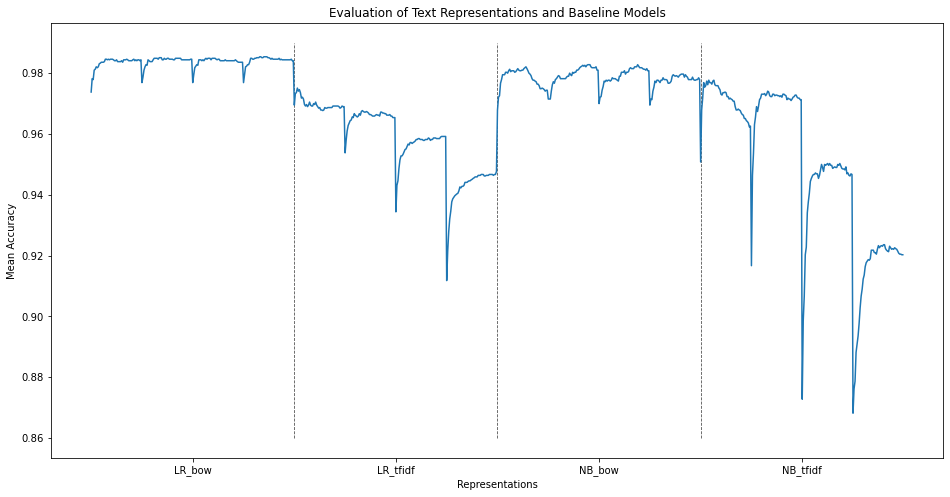

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 8))
plt.plot(tidy_df['mean_accuracy'])
plt.title('Evaluation of Text Representations and Baseline Models')
plt.ylabel('Mean Accuracy')
plt.xlabel('Representations')
plt.vlines(x=[200,400,600], ymin=.86, ymax=.99, colors='k', linewidth=.8, linestyle='dashed', alpha=.7)
plt.xticks(np.arange(100, 900, 200), list(np.unique(tidy_df['representation'])))
plt.show()

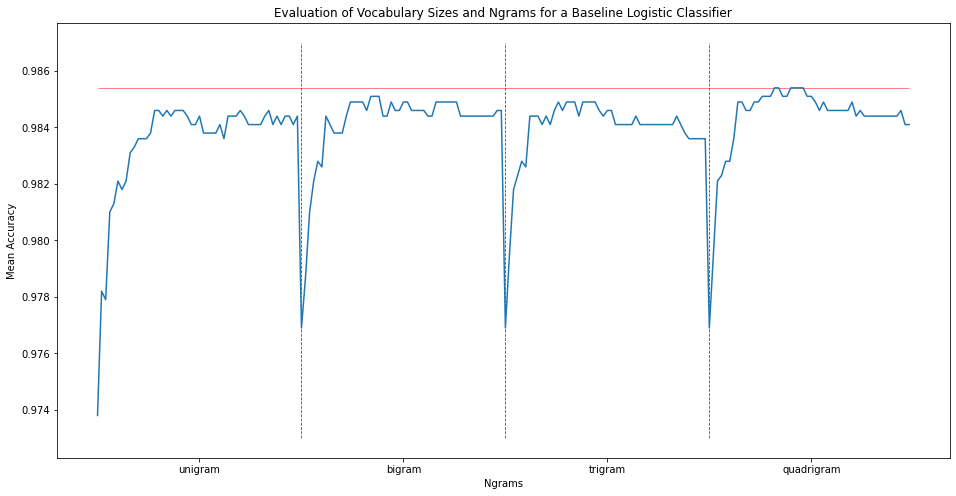

In [11]:
# subset to Logistic Regression on Bag-of-Nwords
LR_bow = tidy_df[tidy_df['representation']=="LR_bow"].copy()

plt.figure(figsize=(16, 8))
plt.plot(LR_bow['mean_accuracy'])
plt.title('Evaluation of Vocabulary Sizes and Ngrams for a Baseline Logistic Classifier')
plt.ylabel('Mean Accuracy')
plt.xlabel('Ngrams')
plt.vlines(x=[50,100,150], ymin=.973, ymax=.987, colors='k', linewidth=.8, linestyle='dashed', alpha=.7)
plt.hlines(y=np.unique(LR_bow['mean_accuracy'][LR_bow['mean_accuracy']==max(LR_bow['mean_accuracy'])])[0],
           xmin=0, xmax=199, colors='r', linewidth=.7, linestyle='solid', alpha=.7)
plt.xticks([25,75,125,175], ['unigram','bigram','trigram','quadrigram'])
plt.show()

In [12]:
# max mean accuracy plateau
LR_bow[LR_bow['mean_accuracy']==max(LR_bow['mean_accuracy'])]

,representation,ngram,vocab_size,mean_accuracy
166,LR_bow,4,1700,0.9854
167,LR_bow,4,1800,0.9854
170,LR_bow,4,2100,0.9854
171,LR_bow,4,2200,0.9854
172,LR_bow,4,2300,0.9854
173,LR_bow,4,2400,0.9854


Are quadrigam's slight gain in accuracy worth the extra time it probably takes to fit them? What are the fitting times?

In [68]:
%%capture output
top_2gram = master_df[master_df['ngram']==2][master_df['vocab_size']==2000]
top_4gram = master_df[master_df['ngram']==4][master_df['vocab_size']==1700]

In [69]:
pd.concat([top_2gram, top_4gram])

,ngram,vocab_size,bow_fit_time,tfidf_fit_time,bow_mod_time,tfidf_mod_time,NB_bow,LR_bow,NB_tfidf,LR_tfidf
69,2,2000,4.2,0.0,0.2,0.1,0.9790,0.9851,0.9723,0.9672
166,4,1700,6.8,0.0,0.2,0.1,0.9779,0.9854,0.9185,0.9428


It probably doesn't matter, it'd seem simpler to just proceed with bigrams as they are faster and perform better with other representations.

In [13]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 17 m 2 s


---